 # Training a baseline Transformer model (vanilla encoder)

In [1]:
import joblib, torch, numpy as np, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    ConfusionMatrixDisplay,
)

 ## Data loading

In [2]:
bundle = joblib.load("baseline_data_processing/data_payload_30s.pkl")
X_train = bundle["X_train"]
y_train = bundle["y_train"]
X_val = bundle["X_val"]
y_val = bundle["y_val"]
X_test = bundle["X_test"]
y_test = bundle["y_test"]

 ## DataLoader setup

In [3]:
DEVICE = "cpu"
BATCH_SIZE = 256
EPOCHS = 25
LR = 1e-3  # will grid-search later


def make_loader(X, y, shuffle):
    tx = torch.tensor(X, dtype=torch.float32)
    ty = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return DataLoader(
        TensorDataset(tx, ty), batch_size=BATCH_SIZE, shuffle=shuffle, drop_last=True
    )


train_loader = make_loader(X_train, y_train, True)
val_loader = make_loader(X_val, y_val, False)
test_loader = make_loader(X_test, y_test, False)

SEQ_LEN, N_FEATS = X_train.shape[1:]

 ## Model definition

 Vanilla Transformer encoder + learnable CLS token -> binary logit.

In [4]:
class PositionalEncoding(nn.Module):
    """Standard sinusoidal encoding, batch_first."""

    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, d_model)

    def forward(self, x):
        return x + self.pe[:, : x.size(1)]


class TransformerClassifier(nn.Module):
    def __init__(
        self, n_feats, d_model=64, n_head=4, n_layers=2, dim_ff=128, dropout=0.1
    ):
        super().__init__()
        self.proj = nn.Linear(n_feats, d_model)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = PositionalEncoding(d_model, max_len=SEQ_LEN + 1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, n_head, dim_ff, dropout, batch_first=True
        )
        self.enc = nn.TransformerEncoder(encoder_layer, n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, 1)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)  # (B, T, d_model)
        cls_token = self.cls.expand(B, -1, -1)  # (B,1,d_model)
        x = torch.cat([cls_token, x], dim=1)  # prepend
        x = self.pos(x)
        enc_out = self.enc(x)  # (B, T+1, d_model)
        cls_out = enc_out[:, 0]  # (B, d_model)
        return self.head(cls_out)


model = TransformerClassifier(n_feats=N_FEATS).to(DEVICE)
print(model)

TransformerClassifier(
  (proj): Linear(in_features=10, out_features=64, bias=True)
  (pos): PositionalEncoding()
  (enc): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


 ## Training & validation loop

In [5]:
models_folder = "baseline_models/"

criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode="min", factor=0.5, patience=2
)


def run_epoch(loader, train):
    tot_loss, correct, total = 0.0, 0, 0
    model.train(train)
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        preds = torch.sigmoid(logits) > 0.5
        correct += (preds.float() == yb).sum().item()
        total += yb.size(0)
        tot_loss += loss.item() * yb.size(0)
    return tot_loss / total, correct / total


best_val, patience, waited = 1e9, 4, 0
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step(va_loss)
    print(
        f"Epoch {epoch:02d} | "
        f"train: {tr_loss:.4f}/{tr_acc:.3f} | "
        f"val: {va_loss:.4f}/{va_acc:.3f}"
    )
    if va_loss < best_val:
        best_val, waited = va_loss, 0
        torch.save(model.state_dict(), models_folder + "best_transformer.pt")
    else:
        waited += 1
        if waited >= patience:
            print("Early stop.")
            break

Epoch 01 | train: 0.4141/0.811 | val: 0.4359/0.793
Epoch 02 | train: 0.3691/0.832 | val: 0.4466/0.790
Epoch 03 | train: 0.3372/0.847 | val: 0.4995/0.785
Epoch 04 | train: 0.3128/0.859 | val: 0.5163/0.789
Epoch 05 | train: 0.2805/0.874 | val: 0.6143/0.761
Early stop.


 ## Test-set evaluation (confusion matrix, recall, specificity, plots)

In [8]:
model.load_state_dict(
    torch.load(models_folder + "best_transformer.pt", map_location=DEVICE)
)
model.eval()

all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logit = model(xb.to(DEVICE))
        all_pred.extend((torch.sigmoid(logit) > 0.5).cpu().numpy().ravel())
        all_true.extend(yb.numpy().ravel())

y_pred = np.array(all_pred, dtype=int)
y_true = np.array(all_true, dtype=int)

cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()
acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN + 1e-12)
spec = TN / (TN + FP + 1e-12)
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.3f}")
print(f"Recall (TPR) : {recall :.3f}")
print(f"Specificity  : {spec :.3f}")
print(f"Precision    : {prec :.3f}")
print(f"F1-score     : {f1 :.3f}")

Confusion matrix (rows: true, cols: pred)
[[23632  4041]
 [ 5298  7221]] 

Accuracy     : 0.768
Recall (TPR) : 0.577
Specificity  : 0.854
Precision    : 0.641
F1-score     : 0.607


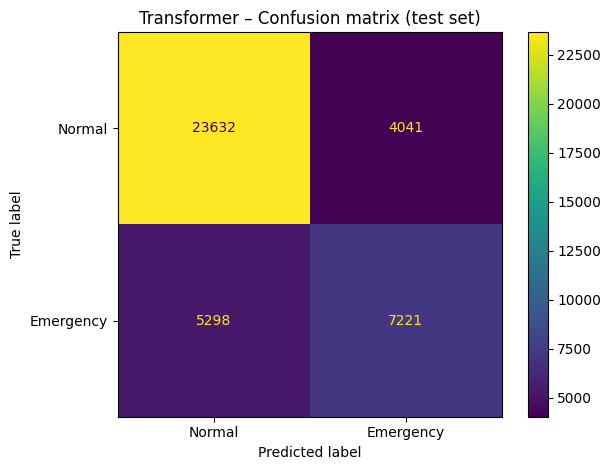

In [ ]:
fig1, ax1 = plt.subplots()

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Normal", "Emergency"]
).plot(ax=ax1)

ax1.set_title("Transformer - Confusion matrix (test set)")
plt.tight_layout()
plt.show()

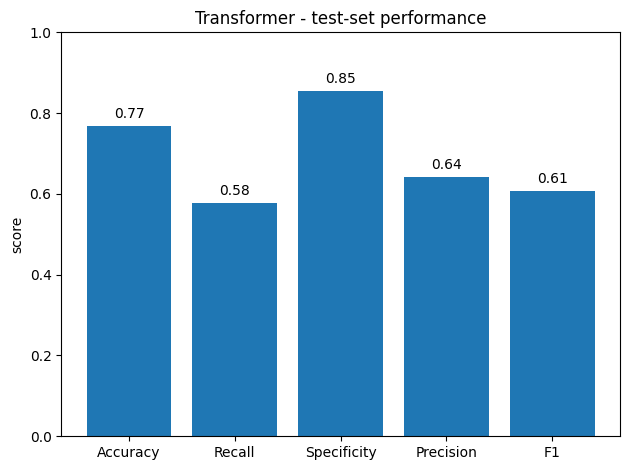

In [11]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "F1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("Transformer - test-set performance")
for i, v in enumerate(metrics):
    ax2.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()